In [102]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
print(tf.config.list_physical_devices()) # Verify you have a GPU available. Not required
print(tf.test.is_built_with_cuda())
print(tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None))
import xgboost as xgb 

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True
True


In [2]:
sr = 100

In [3]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, sr, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [4]:

import numpy as np
from scipy import signal

def normalize(X, shape = False):
    # Compute mean and standard deviation along axis 1 and 2
    X_mean = np.mean(X)
    X_std = np.std(X)

    if(shape):
        print(X.shape)
    # Normalize data by subtracting mean and dividing by standard deviation
    return ((X - X_mean) / X_std)

#____________________________________________________________________________________#

bld = 0.5
def baseline_drift(X, baseline, range = 0):
    bld_range = (baseline-range, baseline+range)
    random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
    return X + random_shifts

#____________________________________________________________________________________#

# Define the filter parameters
fs = 100  # Sampling frequency (Hz)
lowcut = 0.5  # Lower cutoff frequency (Hz)
highcut = 40.0  # Higher cutoff frequency (Hz)
filter_order = 4  # Filter order

def bandpass(X, fs, lowcut, highcut, filter_order):
    # Apply bandpass filter to each channel
    filtered_data = np.zeros_like(X)
    for i in range(X.shape[2]):
        for j in range(X.shape[0]):
            b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
            filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

    # Print the shape of the filtered data
    return filtered_data

#____________________________________________________________________________________#

def da_apply(X, functions, shape = False):
    X_final = X.copy()

    # Applys DA Augments in specified order
    for func_dict in functions:
        func = func_dict['func']
        if(func_dict['params'] == None):
            X_final = func(X_final)     
        else:
            params = func_dict['params']
            X_final = func(X_final, *params)  

    if(shape == True):
        print(X_final.shape)

    return X_final

#func_dict = [{'func': normalize, 'params': [None]}]

#func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]

# func_dict =[{'func': normalize, 'params': [None]},
#             {'func': bandpass, 'params': [100, 0.5, 10, 3]}, # 100, 0.5, 10, 3
#             {'func': baseline_drift, 'params': [0,0.075]}]

In [5]:

with tf.device('/CPU:0'):
    func_dict =[{'func': normalize, 'params': [None]},  # Normalizing across the entire data set instead of by lead
                {'func': baseline_drift, 'params': [0,0.075]}]  # I found that simulating a 0.075 drift works best
    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

In [6]:

with tf.device('/CPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].sex

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].sex

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].sex

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return X_train, y_train, X_val, y_val, X_test, y_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 1000, 12), (17418,), (2183, 1000, 12), (2183,), (2198, 1000, 12), (2198,))


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.models import Model

### Checkpoint Callback
* I realized that I could actually take a checkpoint if my model's performance spikes in the middle of training. 
* This allows me to save the best performance of the model at any point rather than the end point

In [55]:
class SaveModelCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(SaveModelCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs['val_accuracy']
        if accuracy >= self.threshold:
            self.model.save_weights(f'best_model_{epoch + 1}.h5')
            print(f'\nModel saved at epoch {epoch + 1} with accuracy {accuracy:.4f}')

### CNN and RNN joint Sex Model
* In conjunction to the Convolution layers, I used two LSTM (Lon Short-Term Memory) layers. 
* LSTM is a type of RNN architecture which excels in capturing generalizing patterns in time-series data. 
* While the Conv layrs capture intricate and spatial patterns, the LSTM layers help to prevent over fitting.

In [63]:
with tf.device('/GPU:0'):
    tf.debugging.disable_traceback_filtering
    # Random Seed
    tf.random.set_seed(13)

    # Batching
    batch_size = 16
    num_epochs = 15
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    # Shuffle and batch the dataset
    dataset = dataset.shuffle(buffer_size=len(X_train))
    dataset = dataset.batch(batch_size)

    # Creating the model
    ecg_sex_model_2 = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters = 32, kernel_size = 8, strides = 4, padding = "valid", activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 64, kernel_size = 7, strides = 2, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=1, strides = 1, padding = "valid"),
        tf.keras.layers.Dropout(0.2, seed = 13),

        tf.keras.layers.Conv1D(filters = 96, kernel_size = 5, strides = 2, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

        tf.keras.layers.Conv1D(filters = 128, kernel_size = 4, strides = 2, padding = "valid", activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool1D(pool_size=1, strides = 1, padding = "valid"),

        tf.keras.layers.LSTM(units = 64, return_sequences=True, activation = 'tanh', bias_regularizer = tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.LSTM(units=64),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(64, activation= 'relu', kernel_regularizer='l1'),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(1, activation= 'sigmoid')
    ])


    # Compiling the model
    ecg_sex_model_2.compile(loss = tf.keras.losses.binary_crossentropy,
                        optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0005),
                        metrics = ['accuracy'])


    # Learning rate scheduler
    early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
    #lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))
    checkpoint_callback = SaveModelCallback(threshold=0.82)



    # Fitting the model
    history = ecg_sex_model_2.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val), callbacks = [checkpoint_callback])

Epoch 1/15
1089/1089 [==============================] - 39s 33ms/step - loss: 1.5902 - accuracy: 0.7536 - val_loss: 0.8168 - val_accuracy: 0.7160
Epoch 2/15
1089/1089 [==============================] - 38s 35ms/step - loss: 0.6358 - accuracy: 0.7850 - val_loss: 0.5483 - val_accuracy: 0.7939
Epoch 3/15
1089/1089 [==============================] - 38s 34ms/step - loss: 0.5331 - accuracy: 0.7978 - val_loss: 0.4980 - val_accuracy: 0.7998
Epoch 4/15
1089/1089 [==============================] - 38s 35ms/step - loss: 0.5061 - accuracy: 0.8039 - val_loss: 0.4964 - val_accuracy: 0.8007
Epoch 5/15
1089/1089 [==============================] - 38s 35ms/step - loss: 0.4863 - accuracy: 0.8142 - val_loss: 0.4941 - val_accuracy: 0.7911
Epoch 6/15
1089/1089 [==============================] - 38s 35ms/step - loss: 0.4725 - accuracy: 0.8205 - val_loss: 0.4957 - val_accuracy: 0.7920
Epoch 7/15
1088/1089 [============================>.] - ETA: 0s - loss: 0.4581 - accuracy: 0.8314
Model saved at epoch 7 wit

### XGBoost (Ensemble Learning)
* Utilizes a boosting algorithm which calculates the gradient of the loss function with respect of the current predictions. 
* I am feeding the XGBooster the weights from the last LSTM layer because at this point in the model it has captured very temporal paterns (Generalized Patterns)

In [182]:
rnn_sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5")

def apply_boost(model, layer_name, X, y):
    feature_extraction_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)


    # Extracting the features from the LSTM layer
    X_features = feature_extraction_model.predict(X) 

    # XGBoost picks off from these layers and applies its own algorithm
    xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1) 
    xgb_model.fit(X_features, y) 

    xgb_probs = xgb_model.predict_proba(X_features)[:, 1]
    model_probs = rnn_sex_model.predict(X)[:, 0]

    # I am taking the average of the prediction probabilities to get a balanced result
    combined_probs = (xgb_probs + model_probs) / 2.0
    combined_preds = np.where((np.squeeze(np.where(combined_probs >= 0.50, 1, 0))) == 1, 1, 0)

    # Returning both the probabilities and predictions
    return combined_probs, combined_preds

In [195]:
combined_probs, combined_preds = apply_boost(rnn_sex_model, 'lstm_64', X_test, y_test)

69/69 [==============================] - 1s 8ms/step


### Evaluating Model

In [185]:
def predict_set(model, X):
    sex_temp = model(tf.convert_to_tensor(X))
    predicted_sex_prob = np.asarray(tf.squeeze(sex_temp))
    predicted_sex = np.where((np.squeeze(np.where(predicted_sex_prob >= 0.50, 1, 0))) == 1, 1, 0)
    return predicted_sex_prob, predicted_sex

In [186]:
rnn_sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/rnn_sex_model_0.8310.h5")
cnn_sex_model = tf.keras.models.load_model("../saved_models/100hz/sex_models/model_1.h5")

with tf.device('/CPU:0'):
    rnn_pred_prob, rnn_pred_sex= predict_set(rnn_sex_model, X_test)
    cnn_pred_prob, cnn_pred_sex= predict_set(cnn_sex_model, X_test)

### Comparing AUCs
* Measures the ability of the model to distinguish between the two classes across different probability thresholds.

In [196]:
from sklearn.metrics import roc_auc_score


# XGBoosted model, RNN model, Pure CNN model
roc_auc_score(y_test, combined_probs), roc_auc_score(y_test, rnn_pred_prob), roc_auc_score(y_test, cnn_pred_prob)

(0.9706723725296508, 0.8923272495839936, 0.8855592718063632)

### Comparing Accuracies
* Provides a simple metric that calculates (True Positives + True Negatives) / Total

In [200]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, combined_preds), accuracy_score(y_test, rnn_pred_sex), accuracy_score(y_test, cnn_pred_sex)

(0.881255686988171, 0.8061874431301183, 0.8061874431301183)

### Visualization

In [218]:
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

def make_confusion_matrix(y_actual, y_pred, classes=None, figsize=(10, 10), text_size=15):
    cm = confusion_matrix(y_actual, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    labels = classes if classes else np.arange(cm.shape[0])
    ax.set(title="Confusion Matrix On Testing Dataset",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    ax.set_xlabel("Predicted label", fontsize=text_size)
    ax.set_ylabel("True label", fontsize=text_size)
    ax.set_title("Confusion Matrix", fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), repeat=2):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black",
                 size=text_size)

    plt.show()


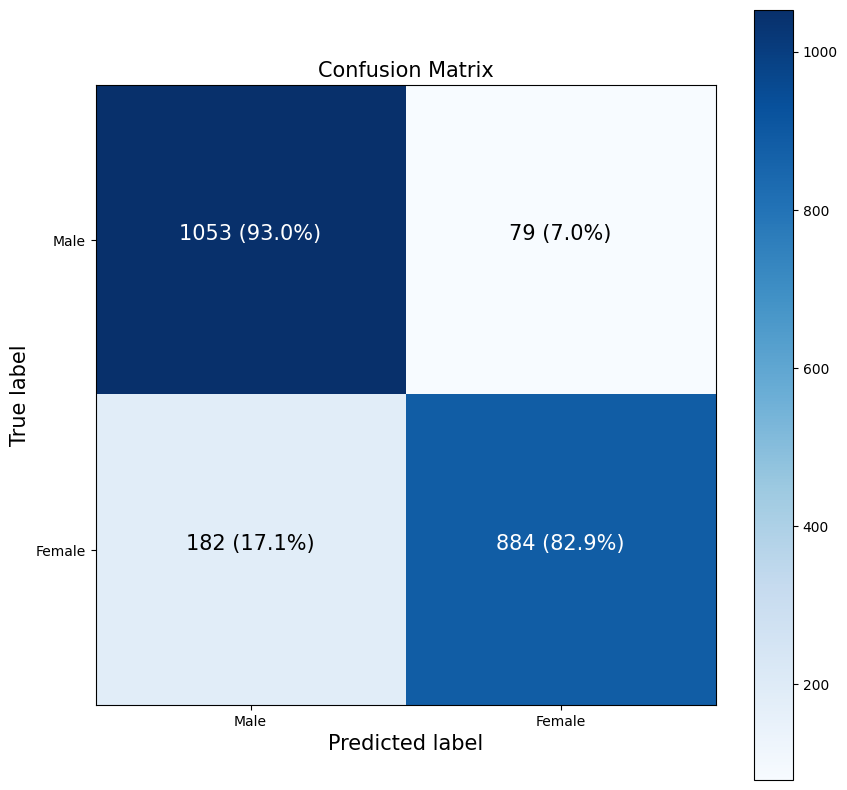

In [219]:
class_name = ['Male', 'Female']
make_confusion_matrix(y_test, combined_preds, class_name)